# Improving Accuracy of Energy Timeseries Forecasts EnBW Datalab

In [1]:
# IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns; sns.set()
import lightgbm as lgb
import math
import smtplib
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pvlib
from datetime import date, timedelta
import holidays
from workalendar.europe import Germany
from datetime import date, timedelta

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error

In [2]:
# Load Data


data = pd.read_csv("./timeseries_data/trafo_67.csv")
data["timestamp"] = pd.to_datetime(data["timestampUtc"])
data_modified = data.drop(columns=["timestampUtc"]).set_index("timestamp")

In [3]:
data_modified

,value,t_2mc,aswdifd_s,aswdir_s,vmax_10m,tot_prec
timestamp,,,,,,
2021-10-01 00:00:00+00:00,-0.089358,5.134399,0.0,0.0,2.764953,0.0
2021-10-01 00:15:00+00:00,-0.086939,5.134399,0.0,0.0,2.764953,0.0
2021-10-01 00:30:00+00:00,-0.137255,5.134399,0.0,0.0,2.764953,0.0
2021-10-01 00:45:00+00:00,-0.066135,5.134399,0.0,0.0,2.764953,0.0
2021-10-01 01:00:00+00:00,-0.073392,4.748993,0.0,0.0,2.036687,0.0
...,...,...,...,...,...,...
2023-09-30 23:00:00+00:00,-0.428512,10.969238,0.0,0.0,2.460899,0.0
2023-09-30 23:15:00+00:00,-0.454154,10.969238,0.0,0.0,2.460899,0.0
2023-09-30 23:30:00+00:00,-0.485602,10.969238,0.0,0.0,2.460899,0.0


### FEATURE ENGINEERING

In [4]:
# Create a Germany calendar instance
germany_calendar = Germany()

# Define the range of years for which you want to get the holidays
start_year = 2019
end_year = 2023

# Initialize an empty DataFrame to store holidays
holidays_df = pd.DataFrame(columns=['date', 'holiday_name'])

# Get holidays for each year and append to the DataFrame
for year in range(start_year, end_year + 1):
    holidays = germany_calendar.holidays(year)
    year_holidays_df = pd.DataFrame(holidays, columns=['date', 'holiday_name'])
    holidays_df = pd.concat([holidays_df, year_holidays_df], ignore_index=True)

holidays_df = holidays_df.sort_values(by='date')

In [5]:
# Co ordinates of Stuttgart for PVLib features

latitude = 48.7758  # Replace with your latitude
longitude = 9.1829  # Replace with your longitude

In [113]:
data_modified_fe = data_modified.copy()

# Encoding local timestamp
data_modified_fe['Day_value_Stamp'] = data_modified.index.hour * 4 + data_modified.index.minute / 15
# Day of the week
data_modified_fe['day_of_week'] = data_modified.index.dayofweek
# Day of the year
data_modified_fe['Day_value_Stamp'] = data_modified.index.dayofyear
# Weekend flag
data_modified_fe['is_weekend'] = (data_modified_fe['day_of_week'] >= 5).astype(int)
# Holidays
data_dates = pd.to_datetime(data_modified_fe.index.date)
data_modified_fe['Holidays'] = data_dates.isin(holidays_df['date']).astype(int)
# Indicator variable for bridge days
data_modified_fe['is_bridgeday'] = (
    (data_modified_fe['day_of_week'] == 0) &  # Monday
    (data_modified_fe['Holidays'].shift(-1) == 1) &  # Holiday on Tuesday
    (data_modified_fe['Holidays'] != 1)  ).astype(int)
# Seasons 0-winter; 1-spring; 2-summer; 3-fall
data_modified_fe["season"] = np.where(data_modified_fe.index.month.isin([12, 1, 2]), 0, 1)
data_modified_fe["season"] = np.where(data_modified_fe.index.month.isin([3, 4, 5]), 1, data_modified_fe["season"])
data_modified_fe["season"] = np.where(data_modified_fe.index.month.isin([6, 7, 8]), 2, data_modified_fe["season"])
data_modified_fe["season"] = np.where(data_modified_fe.index.month.isin([9, 10, 11]), 3, data_modified_fe["season"])


# Feature based on Solar position: zenith and azimuth angles
data_modified_fe['latitude'] = latitude
data_modified_fe['longitude'] = longitude
solar_position = pvlib.solarposition.get_solarposition(
    data_modified_fe.index , data_modified_fe['latitude'], data_modified_fe['longitude']  )
zenith_angle = solar_position['apparent_zenith']
azimuth_angle = solar_position['azimuth']

data_modified_fe['zenith_angle'] = zenith_angle
data_modified_fe['azimuth_angle'] = azimuth_angle
data_modified_fe.drop(columns=["latitude", "longitude"], inplace=True)



#Lag features
data_modified_fe['lag_1'] = data_modified_fe['value'].shift(1)
data_modified_fe['lag_2'] = data_modified_fe['value'].shift(2)
data_modified_fe['lag_3'] = data_modified_fe['value'].shift(3)
data_modified_fe['lag_4'] = data_modified_fe['value'].shift(4)
data_modified_fe['lag_daily'] = data_modified_fe['value'].shift(96)
data_modified_fe['lag_weekly'] = data_modified_fe['value'].shift(672)
data_modified_fe['lag_yearly'] = data_modified_fe['value'].shift(35040)


# Rolling window features

data_modified_fe['value_rolling_mean_6_hourly'] = data_modified_fe['value'].rolling(24, center=True).mean()
data_modified_fe['value_rolling_mean_12_hourly'] = data_modified_fe['value'].rolling(48, center=True).mean()


data_modified_fe['temp_rolling_mean_6_hourly'] = data_modified_fe['t_2mc'].rolling(24, center=True).mean()
data_modified_fe['temp_rolling_mean_12_hourly'] = data_modified_fe['t_2mc'].rolling(48, center=True).mean()
#data_modified_fe['temp_ewm_12_hourly'] = data_modified_fe['t_2mc'].ewm(span=48, adjust=True).mean()

data_modified_fe['aswdifd_s_rolling_mean_12_hourly'] = data_modified_fe['aswdifd_s'].rolling(48, center=True).mean()
data_modified_fe['aswdifd_s_rolling_mean_6_hourly'] = data_modified_fe['aswdifd_s'].rolling(24, center=True).mean()

data_modified_fe['aswdir_s_rolling_mean_12_hourly'] = data_modified_fe['aswdir_s'].rolling(48, center=True).mean()

data_modified_fe['vmax_10m_rolling_mean_12_hourly'] = data_modified_fe['vmax_10m'].rolling(48, center=True).mean()

data_modified_fe['tot_prec_rolling_mean_12_hourly'] = data_modified_fe['tot_prec'].rolling(48, center=True).mean()





In [114]:
data_modified_fe.head(97)

,value,t_2mc,aswdifd_s,aswdir_s,vmax_10m,tot_prec,Day_value_Stamp,day_of_week,is_weekend,Holidays,...,lag_yearly,value_rolling_mean_6_hourly,value_rolling_mean_12_hourly,temp_rolling_mean_6_hourly,temp_rolling_mean_12_hourly,aswdifd_s_rolling_mean_12_hourly,aswdifd_s_rolling_mean_6_hourly,aswdir_s_rolling_mean_12_hourly,vmax_10m_rolling_mean_12_hourly,tot_prec_rolling_mean_12_hourly
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-01 00:00:00+00:00,-0.089358,5.134399,0.0,0.0,2.764953,0.000000,274,4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01 00:15:00+00:00,-0.086939,5.134399,0.0,0.0,2.764953,0.000000,274,4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01 00:30:00+00:00,-0.137255,5.134399,0.0,0.0,2.764953,0.000000,274,4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01 00:45:00+00:00,-0.066135,5.134399,0.0,0.0,2.764953,0.000000,274,4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01 01:00:00+00:00,-0.073392,4.748993,0.0,0.0,2.036687,0.000000,274,4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 23:00:00+00:00,-0.310945,11.056458,0.0,0.0,10.978998,0.007478,274,4,0,0,...,NaN,-0.216157,-0.022238,11.037170,11.701767,0.001091,0.0,0.000180,7.273303,0.003535
2021-10-01 23:15:00+00:00,-0.351585,11.056458,0.0,0.0,10.978998,0.007478,274,4,0,0,...,NaN,-0.250488,-0.046822,10.967599,11.592204,0.139436,0.0,0.001012,7.297712,0.004223
2021-10-01 23:30:00+00:00,-0.357391,11.056458,0.0,0.0,10.978998,0.007478,274,4,0,0,...,NaN,-0.280908,-0.073452,10.898028,11.482641,0.277780,0.0,0.001844,7.322121,0.004912


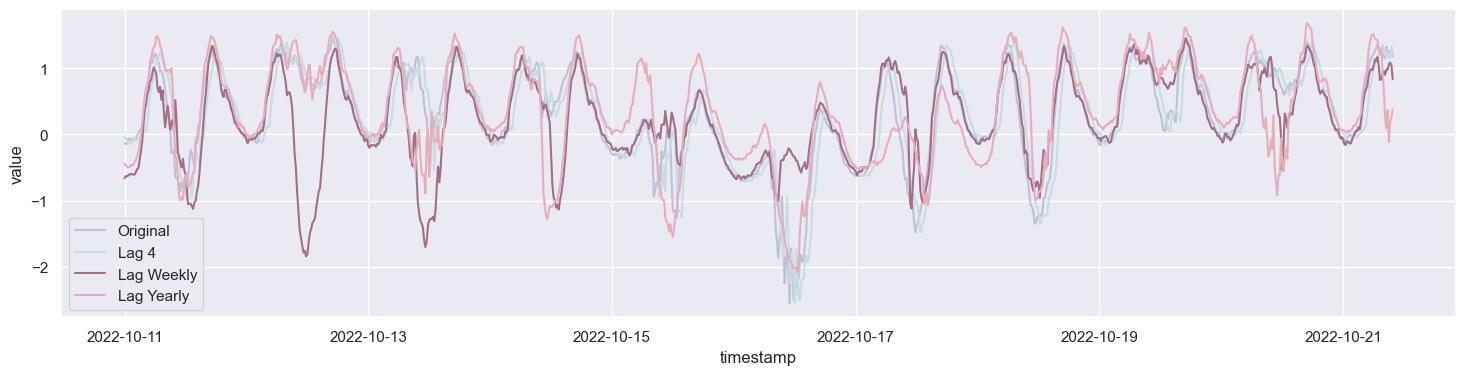

In [103]:
# LAG FEATURES DISPLAY


color_2 = '#C1C1D5'
color_3 = '#A16F86'
color_4 = '#E8AEB7'
color_5 = '#C8DDE1'


plt.figure(figsize=(18, 30))
plt.subplot(611)
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='value', color=color_2, label='Original')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='lag_4', color=color_5, label='Lag 4')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='lag_weekly', color=color_3, label='Lag Weekly')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='lag_yearly', color=color_4, label='Lag Yearly')

plt.legend()  # Add legend
plt.subplots_adjust(hspace=0.3)
plt.show()

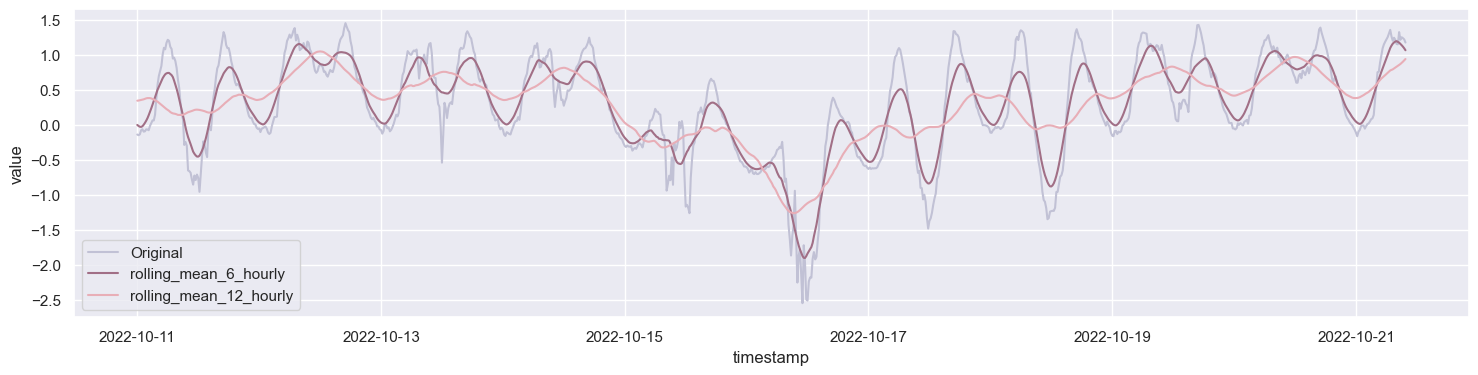

In [115]:
# Display Rolling Window value 	    




plt.figure(figsize=(18, 30))
plt.subplot(611)
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='value', color=color_2, label='Original')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='value_rolling_mean_6_hourly', color=color_3, label='rolling_mean_6_hourly')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='value_rolling_mean_12_hourly', color=color_4, label='rolling_mean_12_hourly')


data_modified_fe['temp_ewm_12_hourly'] = data_modified_fe['t_2mc'].ewm(span=48, adjust=True).mean()



plt.legend()  # Add legend
plt.subplots_adjust(hspace=0.3)
plt.show()

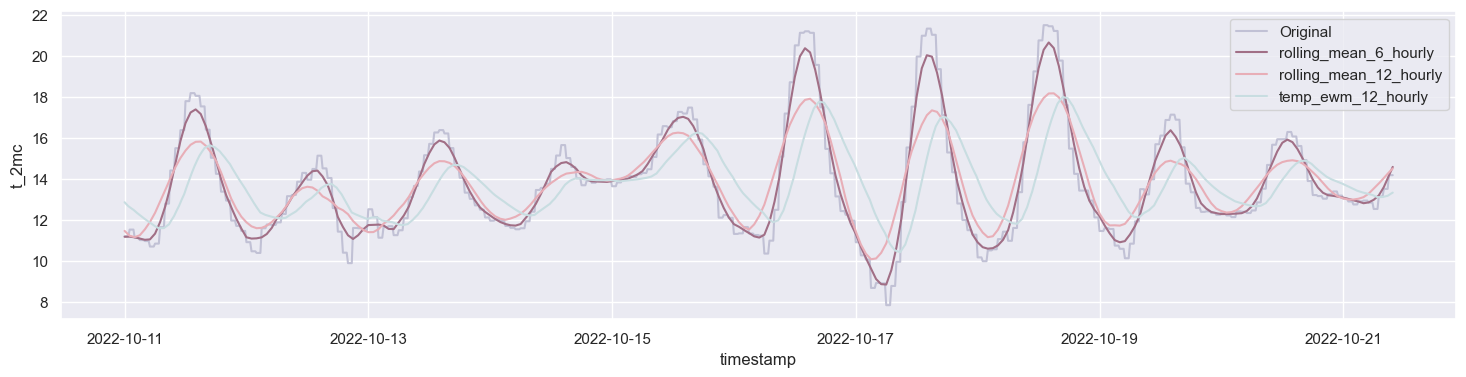

In [108]:
# Display Rolling Window Temp   	    




plt.figure(figsize=(18, 30))
plt.subplot(611)
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='t_2mc', color=color_2, label='Original')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='temp_rolling_mean_6_hourly', color=color_3, label='rolling_mean_6_hourly')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='temp_rolling_mean_12_hourly', color=color_4, label='rolling_mean_12_hourly')
#sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='temp_ewm_12_hourly', color=color_5, label='temp_ewm_12_hourly')

data_modified_fe['temp_ewm_12_hourly'] = data_modified_fe['t_2mc'].ewm(span=48, adjust=True).mean()



plt.legend()  # Add legend
plt.subplots_adjust(hspace=0.3)
plt.show()

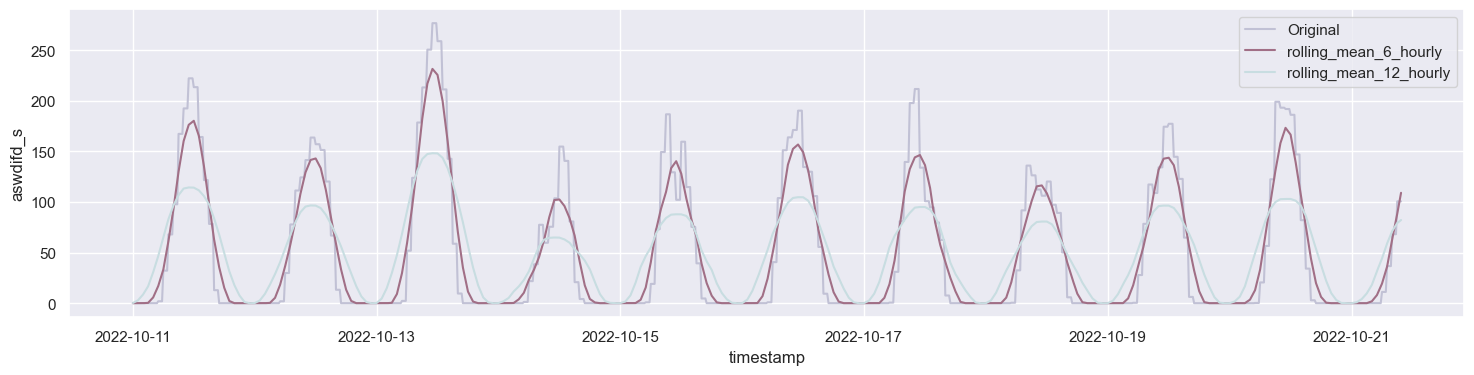

In [105]:
# Display Rolling Window aswdifd_s	    




plt.figure(figsize=(18, 30))
plt.subplot(611)
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='aswdifd_s', color=color_2, label='Original')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='aswdifd_s_rolling_mean_6_hourly', color=color_3, label='rolling_mean_6_hourly')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='aswdifd_s_rolling_mean_12_hourly', color=color_5, label='rolling_mean_12_hourly')



plt.legend()  # Add legend
plt.subplots_adjust(hspace=0.3)
plt.show()

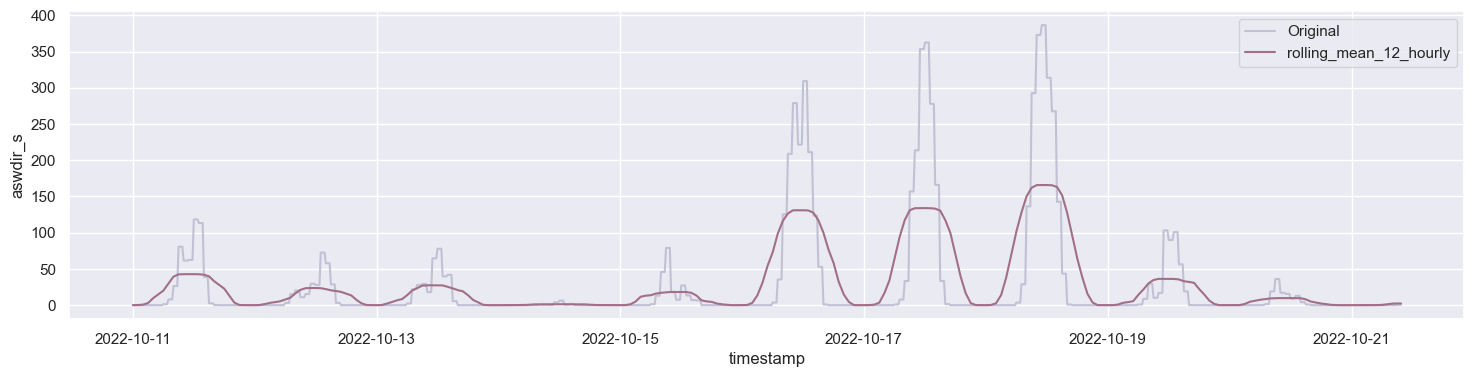

In [110]:
# Display Rolling Window aswdifd_s	    




plt.figure(figsize=(18, 30))
plt.subplot(611)
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='aswdir_s', color=color_2, label='Original')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='aswdir_s_rolling_mean_12_hourly', color=color_3, label='rolling_mean_12_hourly')




plt.legend()  # Add legend
plt.subplots_adjust(hspace=0.3)
plt.show()


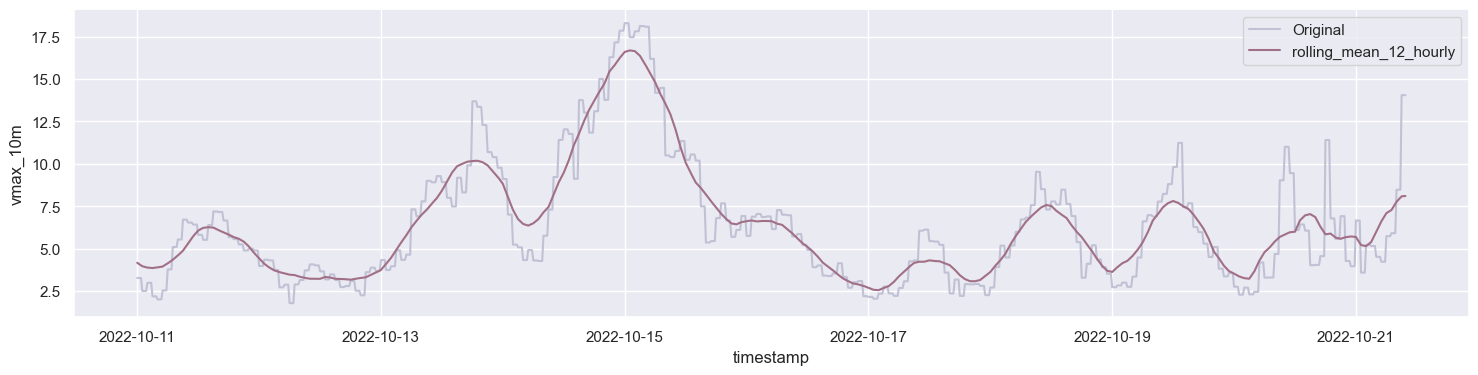

In [111]:
# Display Rolling Window aswdifd_s	    




plt.figure(figsize=(18, 30))
plt.subplot(611)
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='vmax_10m', color=color_2, label='Original')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='vmax_10m_rolling_mean_12_hourly', color=color_3, label='rolling_mean_12_hourly')



plt.legend()  # Add legend
plt.subplots_adjust(hspace=0.3)
plt.show()


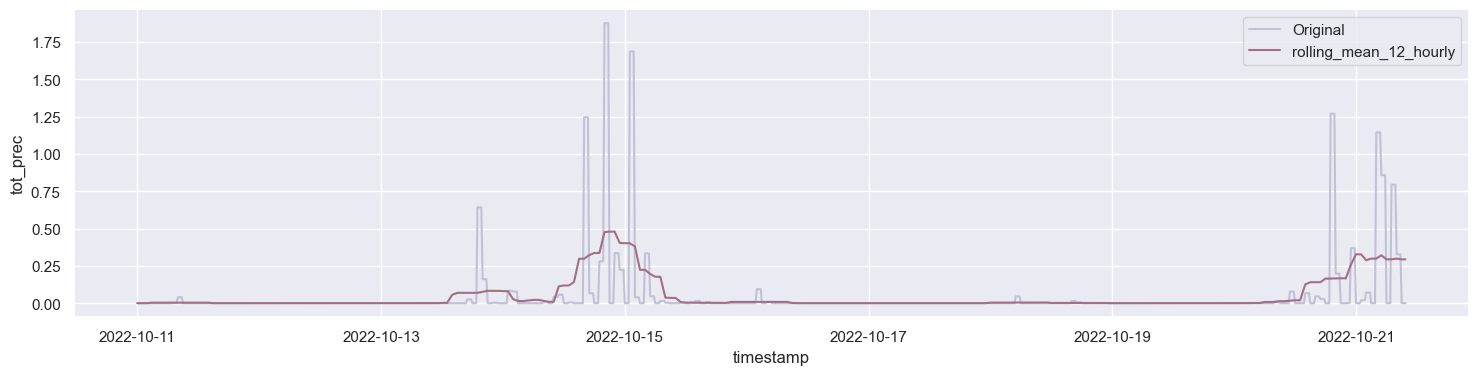

In [112]:

# Display Rolling Window aswdifd_s	    




plt.figure(figsize=(18, 30))
plt.subplot(611)
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='tot_prec', color=color_2, label='Original')
sns.lineplot(data=data_modified_fe[36000:37000], x='timestamp', y='tot_prec_rolling_mean_12_hourly', color=color_3, label='rolling_mean_12_hourly')



plt.legend()  # Add legend
plt.subplots_adjust(hspace=0.3)
plt.show()
